<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Notes/Basic_text_classification_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Train a binary classifier to perform sentiment analysis on an IMDB dataset.

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

## Sentiment analysis
This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the Large Movie Review Dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.


**Download and explore the IMDB dataset**

Let's download and extract the dataset, then explore the directory structure.

**`tf.keras.utils.get_file`**
By default the file at the url origin is downloaded to the cache_dir ~/.keras, placed in the cache_subdir datasets, and given the filename fname. The final location of a file example.txt would therefore be ~/.keras/datasets/example.txt.

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname='aclImdb_v1',
                                  origin=url,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir=''
                                  )


84131840/84125825 [==============================] - 3s 0us/step


In [ ]:
print('path to downloaded file is ',dataset)

path to downloaded file is  ./aclImdb_v1


In [ ]:
os.listdir('.')

['.config', 'aclImdb', 'aclImdb_v1.tar.gz', 'sample_data']

In [ ]:
dataset_dir =  os.path.join(os.path.dirname(dataset),'aclImdb')
print('directory ',dataset_dir)

directory  ./aclImdb


In [ ]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'test', 'README', 'train']

In [ ]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_pos.txt',
 'urls_neg.txt',
 'labeledBow.feat',
 'pos',
 'neg',
 'urls_unsup.txt',
 'unsup',
 'unsupBow.feat']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [ ]:
sample_file = os.path.join(train_dir,'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## Load the dataset
Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful **`text_dataset_from_directory`** utility, which expects a directory structure as follows.

**If your directory structure is:**

main_directory/<br>
...**class_a**/<br>
......a_text_1.txt<br>
......a_text_2.txt<br>
...**class_b**/<br>
......b_text_1.txt<br>
......b_text_2.txt<br>

Then calling text_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of texts from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

Only .txt files are supported at this time.

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to class_a and class_b. These will be the positive and negative movie reviews, which can be found in aclImdb/train/pos and aclImdb/train/neg. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [ ]:
for item in os.listdir(train_dir):
    if os.path.isdir(os.path.join(train_dir,item)):
      print('directory found:',item)

directory found: pos
directory found: neg
directory found: unsup


**rmdir()** method in Python is used to remove or delete a empty directory. OSError will be raised if the specified path is not an empty directory.

By design, rmtree fails on folder trees containing read-only files. If you want the folder to be deleted regardless of whether it contains read-only files, then use

**shutil.rmtree('/folder_name', ignore_errors=True)**


In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
print('directory to remove', remove_dir)

directory to remove ./aclImdb/train/unsup


In [ ]:
import shutil

shutil.rmtree(remove_dir)

In [ ]:
for item in os.listdir(train_dir):
    if os.path.isdir(os.path.join(train_dir,item)):
      print('directory found:',item)

directory found: pos
directory found: neg


Next, you will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset.

tf.data is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: train, validation, and test.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the validation_split argument below.

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(directory=train_dir,
                                                                  labels='inferred',
                                                                  batch_size=batch_size,
                                                                  seed=seed,
                                                                  validation_split=0.2,
                                                                  subset='training')

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to model.fit. If you're new to tf.data, you can also iterate over the dataset and print out a few examples as follows.

In [ ]:
text_batch,label_batch = next(iter(raw_train_ds))

print('Number of reviews in a batch :', len(text_batch))

print('TEXT')
for i in range(5):
  print(text_batch[i])

print('LABELS')
for i in range(5):
  print(label_batch[i])

Number of reviews in a batch : 32
TEXT
tf.Tensor(b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)', shape=(), dtype=string)
tf.Tensor(b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with 

**Notice the reviews contain raw text (with punctuation and occasional HTML tags like <br/>).**

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the **class_names** property on the dataset.

In [ ]:
print('Label 0 corresponds to ',raw_train_ds.class_names[0])
print('Label 1 corresponds to ',raw_train_ds.class_names[1])

Label 0 corresponds to  neg
Label 1 corresponds to  pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

**Note: When using the validation_split and subset arguments, make sure to either specify a random seed, or to pass shuffle=False, so that the validation and training splits have no overlap.**

In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(directory=train_dir,
                                                                labels='inferred',
                                                                batch_size=batch_size,
                                                                seed=seed,
                                                                validation_split=0.2,
                                                                subset='validation')

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
# test directory
test_dir = os.path.join(dataset_dir,'test')
print('directory containing test data ', test_dir)

directory containing test data  ./aclImdb/test


In [ ]:
os.listdir(test_dir)

['urls_pos.txt', 'urls_neg.txt', 'labeledBow.feat', 'pos', 'neg']

In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(directory=test_dir, batch_size=32)

Found 25000 files belonging to 2 classes.


## Prepare the dataset for training
Next, you will standardize, tokenize, and vectorize the data using the helpful preprocessing.TextVectorization layer.

**Standardization** refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.

**Tokenization** refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). 

**Vectorization** refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like ` <br />`. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). we have to write a custom standardization function to remove the HTML.

Note: to prevent train/test skew (also know as train/serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the TextVectorization layer can be included directly inside your model.

### Training-Serving Skew
Training-serving skew is a difference between performance during training and performance during serving. This skew can be caused by:

* A discrepancy between how you handle data in the training and serving pipelines.
* A change in the data between when you train and when you serve.
* A feedback loop between your model and your algorithm.


In [ ]:
# Custom standardization function to remove the HTML.

import string 
import re

In [ ]:
print('Punctuations',string.punctuation)

Punctuations !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
reg = '[%s]' % re.escape(string.punctuation)
pat = re.compile(reg)
re.findall(pat,'hello! john* ')

['!', '*']

In [ ]:
tf.strings.regex_replace("Text with tags.<br /><b>contains html</b>", "<[^>]+>", " ")

<tf.Tensor: shape=(), dtype=string, numpy=b'Text with tags.  contains html '>

In [ ]:
tf.strings.regex_replace("Crimes contributes to about 10% of the movie\'s appeal; the other 90% can be attributed to it\'s flagrant",'[%s]'% string.punctuation, " ")

<tf.Tensor: shape=(), dtype=string, numpy=b'Crimes contributes to about 10  of the movie s appeal  the other 90  can be attributed to it s flagrant'>

In [ ]:
tf.strings.regex_replace("Crimes contributes to about 10% of the movie\'s appeal; the other 90% can be attributed to it\'s flagrant",'[%s]'% re.escape(string.punctuation), " ")

<tf.Tensor: shape=(), dtype=string, numpy=b'Crimes contributes to about 10  of the movie s appeal  the other 90  can be attributed to it s flagrant'>

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [ ]:
# example of standardized text
text = text_batch[0]
print('Before standardization',text)
print('After standardization',custom_standardization(text))

Before standardization tf.Tensor(b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)', shape=(), dtype=string)
After standardization tf.Tensor(b'pandemonium is a horror movie spoof that comes off more stupid than funny believe me when i tell you i love comedies especially comedy spoofs airplane 

Next, you will create a **TextVectorization layer**. You will use this layer to **`standardize`**, **`tokenize`**, and **`vectorize`** our data. You set the output_mode to **int** to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.

**tf.keras.layers.experimental.preprocessing.TextVectorization**

This layer has basic options for managing text in a Keras model. 

It transforms a batch of strings (one sample = one string) into either a list of token indices (one sample = 1D tensor of integer token indices) or a dense representation (one sample = 1D tensor of float values representing data about the sample's tokens).

If desired, the user can call this layer's adapt() method on a dataset. When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a 'vocabulary' from them. This vocabulary can have unlimited size or be capped, depending on the configuration options for this layer; if there are more unique values in the input than the maximum vocabulary size, the most frequent terms will be used to create the vocabulary.

The processing of each sample contains the following steps:

* standardize each sample (usually lowercasing + punctuation stripping)
* split each sample into substrings (usually words)
* recombine substrings into tokens (usually ngrams)
* index tokens (associate a unique int value with each token)
* transform each sample using this index, either into a vector of ints or a dense float vector.


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(max_tokens=max_features,
                                    standardize = custom_standardization,
                                    output_mode='int',
                                    output_sequence_length = sequence_length)

Next, you will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: it's important to only use your training data when calling adapt (using the test set would leak information).

In [ ]:
# Make a text-only dataset (without labels), then call adapt

train_text = raw_train_ds.map(lambda x, y: x)

vectorize_layer.adapt(train_text)

In [ ]:
vectorize_layer.get_vocabulary()[:15]

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'was',
 'as']

In [ ]:
print('length of vocabulary',len(vectorize_layer.get_vocabulary()))

length of vocabulary 10000


Let's create a function to see the result of using this layer to preprocess some data.

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text),label

In [ ]:
firstReview, firstLabel = text_batch[0], label_batch[0]
print('Review ',firstReview)
print('label',firstLabel)
print('label class', raw_train_ds.class_names[firstLabel])
print(vectorize_text(firstReview,firstLabel))

Review  tf.Tensor(b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)', shape=(), dtype=string)
label tf.Tensor(0, shape=(), dtype=int32)
label class neg
(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4,  191,   17, 2926,   12,  255,  127,   50,  377,
          70,  160,

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [ ]:
vectorize_layer.get_vocabulary()[1]

'[UNK]'

In [ ]:
vectorize_layer.get_vocabulary()[7]

'is'

In [ ]:
vectorize_layer.get_vocabulary()[4]

'a'

In [ ]:
vectorize_layer.get_vocabulary()[191]

'horror'

In [ ]:
vectorize_layer.get_vocabulary()[17]

'movie'

You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Configure the dataset for performance
These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
# config for performance
def config_for_performance(ds):
  ds = ds.cache()
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

train_ds = config_for_performance(train_ds)
val_ds = config_for_performance(val_ds)
test_ds = config_for_performance(test_ds)

## Create the model
It's time to create our neural network:

**Embedding layer**

tf.keras.layers.Embedding(<br>
    input_dim,<br>
    output_dim,<br>
    embeddings_initializer="uniform",<br>
    embeddings_regularizer=None,<br>
    activity_regularizer=None,<br>
    embeddings_constraint=None,<br>
    mask_zero=False,<br>
    input_length=None,<br>
    **kwargs<br>
)<br>

Turns positive integers (indexes) into dense vectors of fixed size.

e.g. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]

### This layer can only be used as the first layer in a model.

**input_dim**: Integer. Size of the vocabulary, i.e.**maximum integer index + 1.**

**output_dim**: Integer. Dimension of the dense embedding.

In [ ]:
embedding_dim = 16

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim = max_features+1 , output_dim = embedding_dim),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(1)

])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_8 ( (None, 16)                0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

The first layer is an **Embedding layer**. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). 

Next, a **GlobalAveragePooling1D** layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
The last layer is densely connected with a single output node.

## Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use losses.BinaryCrossentropy loss function.

Now, configure the model to use an optimizer and a loss function:


In [ ]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.BinaryAccuracy(threshold=0.0))

## Train the model
You will train the model by passing the dataset object to the fit method.

In [ ]:
epochs = 10

history = model.fit(x=train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    )

Epoch 1/10
625/625 [==============================] - 6s 8ms/step - loss: 0.6652 - binary_accuracy: 0.6885 - val_loss: 0.6163 - val_binary_accuracy: 0.7696
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5492 - binary_accuracy: 0.8015 - val_loss: 0.4986 - val_binary_accuracy: 0.8212
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4447 - binary_accuracy: 0.8449 - val_loss: 0.4201 - val_binary_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3784 - binary_accuracy: 0.8665 - val_loss: 0.3739 - val_binary_accuracy: 0.8606
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3358 - binary_accuracy: 0.8791 - val_loss: 0.3451 - val_binary_accuracy: 0.8674
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3053 - binary_accuracy: 0.8882 - val_loss: 0.3262 - val_binary_accuracy: 0.8718
Epoch 7/10
625/625 [==============================] - 5s 8ms/ste

## Evaluate the model
Let's see how the model performs. Two values will be returned. 
**Loss** (a number which represents our error, lower values are better), and **accuracy**.

In [ ]:
loss, accuracy = model.evaluate(test_ds)

782/782 [==============================] - 1s 2ms/step - loss: 0.3103 - binary_accuracy: 0.8730


In [ ]:
print('Model Accuracy',accuracy)
print('Model loss',loss)

Model Accuracy 0.8730000257492065
Model loss 0.31029194593429565


This fairly naive approach achieves an accuracy of about 86%.

## Create a plot of accuracy and loss over time
model.fit() returns a History object that contains a dictionary with everything that happened during training:

In [ ]:
history_dict = history.history
print('keys in history dict are ',history_dict.keys())

keys in history dict are  dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

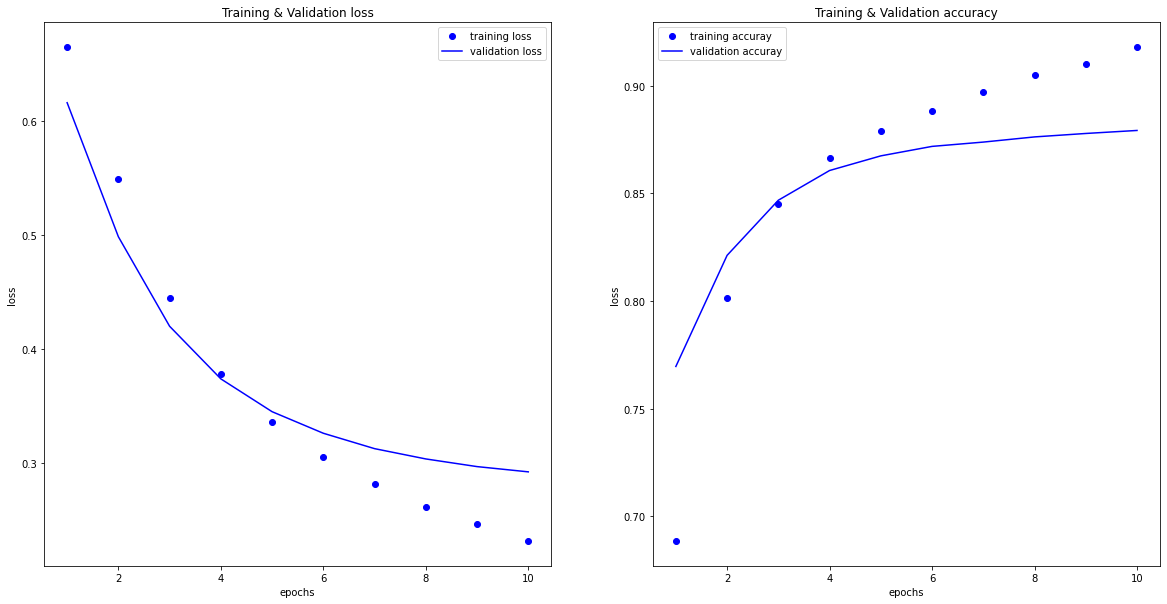

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,11)

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training & Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='training accuray')
plt.plot(epochs, val_acc, 'b', label='validation accuray')
plt.title('Training & Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the tf.keras.callbacks.EarlyStopping callback.

In [ ]:
final_model = tf.keras.Sequential([
                                   tf.keras.layers.Embedding(input_dim=max_features+1, output_dim=16),
                                   tf.keras.layers.Dropout(0.2),
                                   tf.keras.layers.GlobalAveragePooling1D(),
                                   tf.keras.layers.Dropout(0.2),
                                   tf.keras.layers.Dense(1)

])

final_model.compile(optimizer='Adam',
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=tf.keras.metrics.BinaryAccuracy())

earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

history= final_model.fit(x=train_ds,
                        epochs=100,
                        validation_data=val_ds,
                         callbacks=[earlyStoppingCallback])

Epoch 1/100
625/625 [==============================] - 5s 8ms/step - loss: 0.6637 - binary_accuracy: 0.5064 - val_loss: 0.6141 - val_binary_accuracy: 0.5316
Epoch 2/100
625/625 [==============================] - 5s 8ms/step - loss: 0.5482 - binary_accuracy: 0.6639 - val_loss: 0.4978 - val_binary_accuracy: 0.7258
Epoch 3/100
625/625 [==============================] - 5s 7ms/step - loss: 0.4437 - binary_accuracy: 0.7918 - val_loss: 0.4195 - val_binary_accuracy: 0.8078
Epoch 4/100
625/625 [==============================] - 5s 8ms/step - loss: 0.3782 - binary_accuracy: 0.8393 - val_loss: 0.3734 - val_binary_accuracy: 0.8324
Epoch 5/100
625/625 [==============================] - 5s 7ms/step - loss: 0.3353 - binary_accuracy: 0.8615 - val_loss: 0.3448 - val_binary_accuracy: 0.8458
Epoch 6/100
625/625 [==============================] - 5s 8ms/step - loss: 0.3048 - binary_accuracy: 0.8766 - val_loss: 0.3258 - val_binary_accuracy: 0.8544
Epoch 7/100
625/625 [==============================] - 5s 

In [ ]:
loss, accuracy = final_model.evaluate(test_ds)
print('Model Accuracy',accuracy)
print('Model loss',loss)

782/782 [==============================] - 1s 2ms/step - loss: 0.3122 - binary_accuracy: 0.8650
Model Accuracy 0.8650000095367432
Model loss 0.31215640902519226


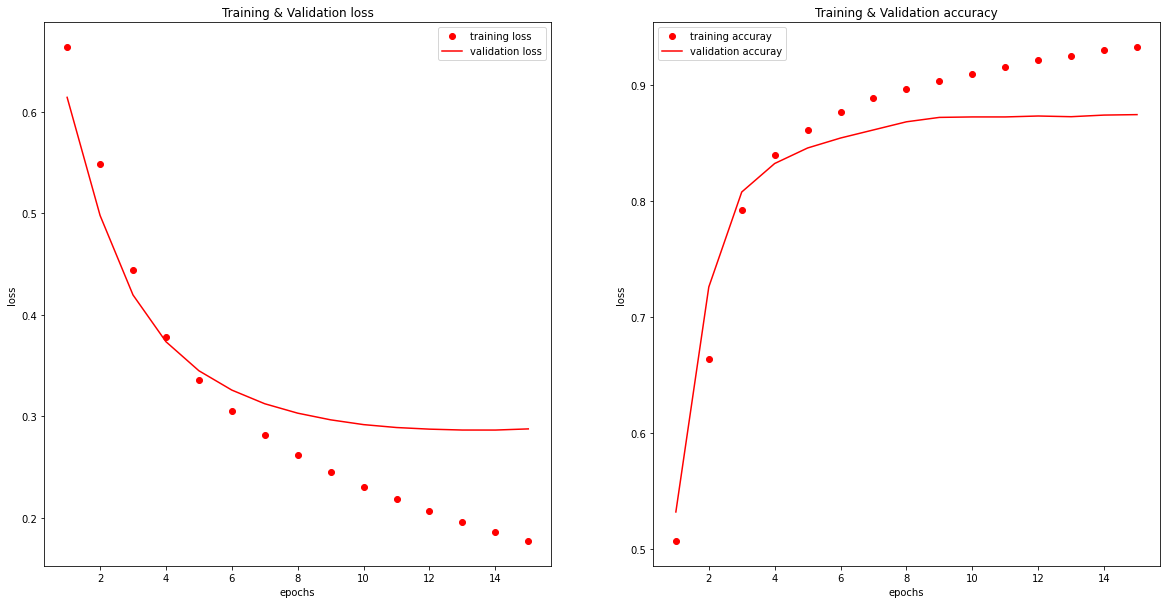

In [ ]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,16)

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'ro', label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('Training & Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='training accuray')
plt.plot(epochs, val_acc, 'r', label='validation accuray')
plt.title('Training & Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

## Export the model
In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [ ]:
export_model = tf.keras.Sequential([
                                  vectorize_layer,
                                  final_model,
                                  tf.keras.layers.Activation('sigmoid')
])

export_model.compile(optimizer='Adam',
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                     metrics=['accuracy']),


# Test it with `raw_test_ds`, which yields raw strings

loss, accuracy = export_model.evaluate(raw_test_ds)

782/782 [==============================] - 11s 14ms/step - loss: 0.3122 - accuracy: 0.8731


In [ ]:
print('Export model Accuray', accuracy)
print('Export model loss', loss)

Export model Accuray 0.8730800151824951
Export model loss 0.3121563196182251


## Inference on new data
To get predictions for new examples, you can simply call model.predict().

In [ ]:

examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6168966 ],
       [0.39585584],
       [0.3008775 ]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for train/test skew.

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer.

Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. 

So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

## Exercise: multi-class classification on Stack Overflow questions

**Train a multi-class classifier to predict the tag of a programming question on Stack Overflow.**

A dataset has been prepared for you to use containing the body of several thousand programming questions (for example, "How can sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python.

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on BigQuery, which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

train/<br>
...python/<br>
......0.txt<br>
......1.txt<br>
...javascript/<br>
......0.txt<br>
......1.txt<br>
...csharp/<br>
......0.txt<br>
......1.txt<br>
...java/<br>
......0.txt<br>
......1.txt<br>
<br>

Note: to increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word blank (as many questions contain the language they're about).





In [3]:
url ='http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset = tf.keras.utils.get_file(fname='stack_overflow',
                                  origin=url,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

6053888/6053168 [==============================] - 0s 0us/step


In [5]:
print('path to dataset',dataset)

path to dataset ./stack_overflow


In [7]:
os.listdir('.')

['.config',
 'README.md',
 'test',
 'stack_overflow.tar.gz',
 'train',
 'sample_data']

In [8]:
train_dir = os.path.join('.','train')
test_dir = os.path.join('.','test')

In [9]:
os.listdir(train_dir)

['python', 'javascript', 'java', 'csharp']

In [11]:
os.listdir(test_dir)

['python', 'javascript', 'java', 'csharp']

We will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. 

`tf.data` is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: train, validation, and test.

**Note: When using the validation_split and subset arguments, make sure to either specify a random seed, or to pass shuffle=False, so that the validation and training splits have no overlap.**

### Load the dataset

In [109]:
batch_size = 32
seed = 42

In [110]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory( directory=train_dir,
                                                                  batch_size=batch_size,
                                                                  seed=seed,
                                                                  validation_split=0.2,
                                                                  subset='training')

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [111]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory( directory=train_dir,
                                                                batch_size=batch_size,
                                                                seed=seed,
                                                                validation_split=0.2,
                                                                subset='validation')

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [112]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(directory=test_dir,
                                                                 batch_size=batch_size,
                                                                 seed=seed)

Found 8000 files belonging to 4 classes.


Let's iterate over the dataset and print out a few examples as follows.

In [113]:
text_batch, label_batch = next(iter(raw_train_ds))

print('Text :  programming questions')
for i in range(5):
  print(text_batch[i])

print('Label :  programming language')
for i in range(5):
  print(label_batch[i], 'classname ', raw_train_ds.class_names[label_batch[i].numpy()])

Text :  programming questions
tf.Tensor(b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but

### Prepare the dataset for training

we will `standardize`, `tokenize`, and `vectorize` the data using the helpful preprocessing.TextVectorization layer.

**Standardization** refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.

**Tokenization** refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). 

**Vectorization** refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

In [147]:
import re
import string

#  let's write a custom standardization function
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase,'<br />', ' ')
  stripped_newline = tf.strings.regex_replace(stripped_html,'\n', '')
  stripped_dot = tf.strings.regex_replace(stripped_newline,'\.{1}', ' ')
  stripped_punctuations = tf.strings.regex_replace(stripped_dot, '[%s]' % re.escape(string.punctuation),' ')
  return  tf.strings.regex_replace(stripped_punctuations,'\s\s+',' ')

In [150]:
# eg of custom standardization

text = text_batch[4]

print('Before standardization')
print("Programming Question",text)
print('After standardization')
print("Programming Question",custom_standardization(text))

Before standardization
Programming Question tf.Tensor(b'"parameter with question mark and super in blank, i\'ve come across a method that is formatted like this:..public final subscription subscribe(final action1&lt;? super t&gt; onnext, final action1&lt;throwable&gt; onerror) {.}...in the first parameter, what does the question mark and super mean?"\n', shape=(), dtype=string)
After standardization
Programming Question tf.Tensor(b' parameter with question mark and super in blank i ve come across a method that is formatted like this public final subscription subscribe final action1 lt super t gt onnext final action1 lt throwable gt onerror in the first parameter what does the question mark and super mean ', shape=(), dtype=string)


Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.

In [151]:
# create a vectorization layer

max_features = 10000
sequence_length = 250

vectorization_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = max_features,
    standardize = custom_standardization,
    output_mode = 'int',
    output_sequence_length = sequence_length
) 

Next, you will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: it's important to only use your training data when calling adapt (using the test set would leak information).

In [152]:
# Make a text-only dataset (without labels), then call adapt

train_text = raw_train_ds.map(lambda x, y: x)

vectorization_layer.adapt(train_text)

In [153]:
vectorization_layer.get_vocabulary()[:10]

['', '[UNK]', 'i', 'the', 'to', 'a', 'gt', 'is', 'lt', 'in']

In [154]:
print('Length of vocabulary is',len(vectorization_layer.get_vocabulary()))

Length of vocabulary is 10000


Let's create a function to see the result of using this layer to preprocess some data.

In [155]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorization_layer(text), label

In [156]:
text = text_batch[4]
label = label_batch[4]

print('Programming Question',text)
print('Programming Label',label)
print('Programming Label class',raw_train_ds.class_names[label.numpy()])
print('Programming Question vectorized',vectorize_text(text, label))

Programming Question tf.Tensor(b'"parameter with question mark and super in blank, i\'ve come across a method that is formatted like this:..public final subscription subscribe(final action1&lt;? super t&gt; onnext, final action1&lt;throwable&gt; onerror) {.}...in the first parameter, what does the question mark and super mean?"\n', shape=(), dtype=string)
Programming Label tf.Tensor(1, shape=(), dtype=int32)
Programming Label class java
Programming Question vectorized (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 468,   34,  184, 1334,   10,  715,    9,   17,    2,  241, 1035,
        1446,    5,   83,   21,    7, 1951,   66,   12,   22,  320,    1,
        4534,  320, 4272,    8,  715,   47,    6,    1,  320, 4272,    8,
        4304,    6, 9668,    9,    3,  125,  468,   62,  154,    3,  184,
        1334,   10,  715,  732,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [157]:
print(vectorization_layer.get_vocabulary()[40])

can


In [158]:
print(vectorization_layer.get_vocabulary()[2])

i


In [159]:
print(vectorization_layer.get_vocabulary()[105])

use


In [160]:
print(vectorization_layer.get_vocabulary()[279])

node


In [161]:
print(vectorization_layer.get_vocabulary()[2419])

childnodes


In [162]:
print(vectorization_layer.get_vocabulary()[9])

in


In [163]:
print(vectorization_layer.get_vocabulary()[3])

the


In [164]:
print(vectorization_layer.get_vocabulary()[14])

if


As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [165]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Configure the dataset for performance
These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

In [166]:
def config_for_preformance(ds):
  ds = ds.cache()
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [167]:
train_ds = config_for_preformance(train_ds)
val_ds = config_for_preformance(val_ds)
test_ds = config_for_preformance(test_ds)

### Create a Model

Embedding layer can only be used as the first layer in a model.

`input_dim`: Integer. Size of the vocabulary, i.e.maximum integer index + 1.

`output_dim`: Integer. Dimension of the dense embedding.

The layers are stacked sequentially to build the classifier:

The Embedding layer takes the integer-encoded programming questions and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

Drop-out layer are added to prevent overfitting

The last layer is densely connected, a Dense(4), as there are now four output classes.

In [191]:
stack_overflow_model = tf.keras.Sequential([
                                            tf.keras.layers.Embedding(input_dim = max_features+1, output_dim=16),
                                            tf.keras.layers.Dropout(0.2),
                                            tf.keras.layers.GlobalAveragePooling1D(),
                                            tf.keras.layers.Dropout(0.2),
                                            tf.keras.layers.Dense(4)
])

When compiling the model, the loss function to use is `tf.keras.losses.SparseCategoricalCrossentropy`. 

This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, 1, 2, or 3).

In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem

(`tf.metrics.BinaryAccuracy` is only used for binary classifiers).



In [192]:
stack_overflow_model.compile(optimizer='Adam',
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                             metrics=['accuracy'])

In [193]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

In [194]:
history = stack_overflow_model.fit(
                x = train_ds,
                validation_data = val_ds,
                epochs=100,
                callbacks = [earlyStoppingCallback]
)

Epoch 1/100
200/200 [==============================] - 2s 7ms/step - loss: 1.3692 - accuracy: 0.4278 - val_loss: 1.3446 - val_accuracy: 0.5306
Epoch 2/100
200/200 [==============================] - 1s 6ms/step - loss: 1.3055 - accuracy: 0.5755 - val_loss: 1.2584 - val_accuracy: 0.6431
Epoch 3/100
200/200 [==============================] - 1s 6ms/step - loss: 1.2002 - accuracy: 0.6656 - val_loss: 1.1421 - val_accuracy: 0.7225
Epoch 4/100
200/200 [==============================] - 1s 6ms/step - loss: 1.0796 - accuracy: 0.7302 - val_loss: 1.0257 - val_accuracy: 0.7500
Epoch 5/100
200/200 [==============================] - 1s 6ms/step - loss: 0.9650 - accuracy: 0.7683 - val_loss: 0.9245 - val_accuracy: 0.7794
Epoch 6/100
200/200 [==============================] - 1s 6ms/step - loss: 0.8624 - accuracy: 0.7983 - val_loss: 0.8409 - val_accuracy: 0.7894
Epoch 7/100
200/200 [==============================] - 1s 6ms/step - loss: 0.7823 - accuracy: 0.8117 - val_loss: 0.7735 - val_accuracy: 0.8006

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [195]:
loss, accuracy = stack_overflow_model.evaluate(test_ds)

print('Model accuracy is',accuracy)
print('Model loss is',loss)

250/250 [==============================] - 0s 1ms/step - loss: 0.3943 - accuracy: 0.8526
Model accuracy is 0.8526250123977661
Model loss is 0.3943123519420624


### create a plot of training accuracy & loss over time

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

In [196]:
history_dict = history.history

history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [197]:
loss = history_dict['loss']
accuracy = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_accuracy = history_dict['val_accuracy']

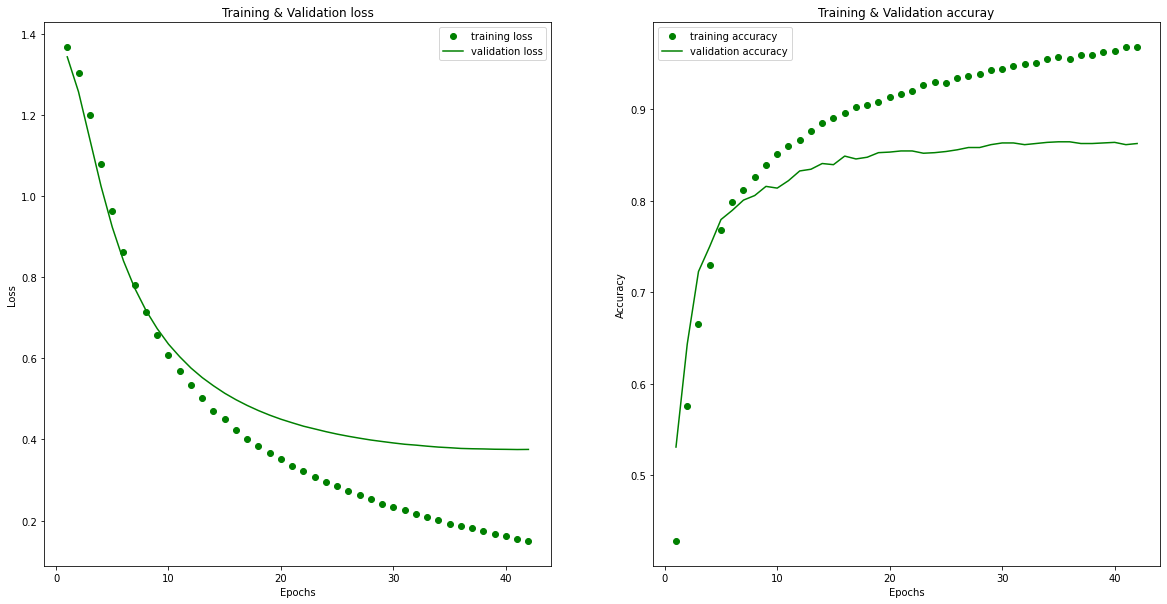

In [201]:
plt.figure(figsize=(20,10))

epochs = range(1, len(loss)+1)

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'og', label='training loss')
plt.plot(epochs, val_loss, 'g', label='validation loss')
plt.title('Training & Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, accuracy, 'og', label='training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='validation accuracy')
plt.title('Training & Validation accuray')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()